In [1]:
import sys
sys.path.append('/home/isabrah/sustainable_high_quality_wikis')
from modeling.modeling_utils import find_optimal_threshold, eval_classification_preds
import pandas as pd
import numpy as np
from os.path import join as opj
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import multiprocess as mp
from scipy.stats import t

In [2]:
def run_cv_process(run_idx, x_data, y_data, classification_model, folds_k=5):
    """
    This function is useful for running CV process in a MP way. It returns an evaluation df of both train and test DFs 
    :param run_idx: int
        a running index of the CV process
    :param x_data: pandas df
        a dataframe with the X matrix to be used for modeling
    :param y_data: pandas series
        the vector of y values to be used while modeling. Should include only 1 and 0
    :param classification_model: sklearn model
        the model to be used while modeling (e.g., LogisticRegression)
    :param folds_k: int, default=5
        number of folds to use for cross-validation
    :return: tuple (size 4)
        run_idx: same value given in input. Makes it easy to follow the results from multiple cores
        eval_measures_train_df: all results (mean and std) of the train data along the k_fold CSs
        eval_measures_test_df: same as the train df above, but for test
        predictions: a list of prediction values over all dataset (based on the prediction per fold we get)
    """
    skf = StratifiedKFold(n_splits=folds_k, shuffle=True, random_state=seed)
    eval_measures_train = dict()
    eval_measures_test = dict()
    predictions = dict()
    feature_importance = defaultdict(float)
    local_y_data = y_data.copy() # for some reason, the y vector cannot be handled without making a local version of it
    for cv_index, (train_index, test_index) in enumerate(skf.split(x_data, local_y_data)):
        x_train, x_test = x_data.iloc[train_index], x_data.iloc[test_index]
        y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
        
        # filling the missing values with the mean
        imputer = SimpleImputer(strategy='mean')
    
        # Fit the imputer on the training data and transform both train and test sets
        x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
        x_test_imputed = pd.DataFrame(imputer.transform(x_test), columns=x_train.columns)
    
        model = classification_model
        model.fit(x_train_imputed, y_train)
          
        # finding the optimal threshold
        y_train_pred_proba = model.predict_proba(x_train_imputed)[:, 1]
        optimal_th = find_optimal_threshold(y_true=y_train, predicted_proba=y_train_pred_proba)
    
        # Evaluate the Model
        y_test_pred_proba = model.predict_proba(x_test_imputed)[:, 1]
        y_pred_test = model.predict(x_test_imputed)
        eval_dict_test = eval_classification_preds(true_values=y_test, preds=y_pred_test,
                                                   preds_proba=y_test_pred_proba, optimal_th=optimal_th)
        eval_dict_train = eval_classification_preds(true_values=y_train, preds=model.predict(x_train_imputed),
                                                    preds_proba=y_train_pred_proba, optimal_th=optimal_th)
    
        eval_measures_train[cv_index] = eval_dict_train
        eval_measures_test[cv_index] = eval_dict_test
        cur_pred_per_page = {page_id: pred for page_id, pred in zip(y_test.index, y_test_pred_proba)}
        predictions.update(cur_pred_per_page)
        # feature importance process
        cur_feature_importance = {f_name: f_importance for f_name, f_importance in zip(model.feature_names_in_, model.feature_importances_)}
        for cfi, value in cur_feature_importance.items():
            feature_importance[cfi] += value
    eval_measures_train_df = pd.DataFrame.from_dict(eval_measures_train, orient='index')
    eval_measures_test_df = pd.DataFrame.from_dict(eval_measures_test, orient='index')
    # append the average values as a new row to the DataFrame
    eval_measures_train_df.loc['mean'] = eval_measures_train_df.mean()
    eval_measures_train_df.loc['std'] = eval_measures_train_df.std()
    eval_measures_test_df.loc['mean'] = eval_measures_test_df.mean()
    eval_measures_test_df.loc['std'] = eval_measures_test_df.std()
    print(f"Run index {run_idx} has ended.")
    return run_idx, eval_measures_train_df, eval_measures_test_df, predictions

### Configurations

In [3]:
model_version = 2.2
target_column = 'is_sustained'
use_only_meta_features = False
model_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'
seed = 1984
classification_model = GradientBoostingClassifier(n_estimators=100)

### Data loading & cleaning

In [4]:
data_df = pd.read_csv(opj(model_folder, str(model_version), 'modeling_df.csv'))
# Set the first column as the index
data_df.set_index(data_df.columns[0], inplace=True)
data_df[target_column] = data_df[target_column].astype(int)
# all features that start with 'TIME_' should not be included in the modeling df
x_columns = [c for c in data_df.columns if c != target_column and not c.startswith('TIME_')]

In [5]:
promotion_column = pd.to_datetime(data_df['TIME_promotion_date'])
demotion_column = pd.to_datetime(data_df['TIME_demotion_date'])

# Calculate the difference in days
time_in_promotion = (demotion_column - promotion_column).dt.days
y_values = data_df[target_column].astype(int)
# extract the quantiles
time_in_promotion_not_nan = [t for t in time_in_promotion if not np.isnan(t)]
time_in_promotion_quantiles = [int(pd.Series(time_in_promotion_not_nan).quantile(q=q/10.0)) for q in range(1,11)]
time_in_promotion_quantiles

[103, 393, 745, 1156, 1834, 2819, 3924, 4970, 5574, 6757]

### Correaltion analysis (did not end up nicely, so no real need to consider)

In [6]:
demoted_pages_promotion_time = {page_id: promotion_time for page_id, promotion_time in time_in_promotion.to_dict().items() if not np.isnan(promotion_time)}
row_lvl_preds = pd.read_csv(opj(model_folder, str(model_version), 'row_lvl_preds.csv'))
row_lvl_preds.set_index(keys='Unnamed: 0', inplace=True, drop=True)
row_lvl_preds_dict = dict(zip(row_lvl_preds.index, row_lvl_preds.iloc[:,0]))
demoted_pages_all_info = {page_id: {'pred': pred, 'promotion_dim': demoted_pages_promotion_time[page_id]} for page_id, pred in row_lvl_preds_dict.items() if page_id in demoted_pages_promotion_time}
len(demoted_pages_all_info)

3121

In [7]:
pd.DataFrame.from_dict(demoted_pages_all_info, orient='index').corr(method='spearman')

,pred,promotion_dim
pred,1.00,-0.01
promotion_dim,-0.01,1.00


### Modeling, each quantile separately (now doing it in a mp way!)

In [8]:
input_for_pool = list()
res_per_quantile = dict()
for run_idx, cur_quantile in enumerate(time_in_promotion_quantiles):
    cur_y_values = [0 if tip <= cur_quantile else 1 for tip in time_in_promotion]
    data_df['cur_y_values'] = pd.Series(cur_y_values).astype(int)
    # if we want to include specific sets of features (e.g., meta)
    if use_only_meta_features:
        x_columns = [c for c in x_columns if c.startswith('META_')]
    x_data = data_df[x_columns].copy()
    y_data = pd.Series(cur_y_values)
    minority_class_prop = round(min(list(Counter(y_data).values())) / len(y_data), 2)
    input_for_pool.append((run_idx, x_data, y_data, classification_model, 5))
    res_per_quantile[run_idx] = {'quantile': cur_quantile, 'n': len(y_data), 'minority_class_prop': minority_class_prop}

In [9]:
pool = mp.Pool(processes=len(input_for_pool))
with pool as pool:
    results = pool.starmap(run_cv_process, input_for_pool)

Run index 1 has ended.
Run index 0 has ended.
Run index 2 has ended.
Run index 3 has ended.
Run index 8 has ended.
Run index 4 has ended.
Run index 7 has ended.
Run index 5 has ended.
Run index 6 has ended.
Run index 9 has ended.


In [30]:
# merging the list of dicts into one dict
for res in results:
    run_idx, eval_measures_df_train, eval_measures_df_test, _ = res
    f1_ci = t.interval(0.95, 5, loc=eval_measures_df_test.loc['mean']['f1_opt_th'],
                       scale=eval_measures_df_test.loc['std']['f1_opt_th'])  # 95% confidence interval
    f1_ci = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, f1_ci)) # rounding the numbers
    auc_ci = t.interval(0.95, 5, loc=eval_measures_df_test.loc['mean']['auc'],
                       scale=eval_measures_df_test.loc['std']['auc'])  # 95% confidence interval
    auc_ci = tuple(map(lambda x: isinstance(x, float) and round(x, 3) or x, auc_ci)) # rounding the numbers
    res_per_quantile[run_idx].update({'train_f1': eval_measures_df_train.loc['mean']['f1_opt_th'],
                                      'train_auc': eval_measures_df_train.loc['mean']['auc'],
                                      'test_f1': eval_measures_df_test.loc['mean']['f1_opt_th'],
                                      'test_auc': eval_measures_df_test.loc['mean']['auc'],
                                      'test_auc_std': eval_measures_df_test.loc['std']['auc'],
                                      'test_f1_std': eval_measures_df_test.loc['std']['f1_opt_th'],
                                      'f1_ci': f1_ci, 'auc_ci': auc_ci})
res_per_quantile_df = pd.DataFrame.from_dict(res_per_quantile, orient='index')

### Analyzing the results

In [31]:
res_per_quantile_df

,quantile,n,minority_class_prop,train_f1,train_auc,test_f1,test_auc,test_auc_std,test_f1_std,f1_ci,auc_ci
0,103,41798,0.01,0.855199,0.906563,0.514451,0.780612,0.028137,0.016160,"(0.473, 0.556)","(0.708, 0.853)"
1,393,41798,0.02,0.748470,0.850832,0.553691,0.780230,0.008404,0.014053,"(0.518, 0.59)","(0.759, 0.802)"
2,745,41798,0.02,0.718454,0.841111,0.593662,0.788135,0.009192,0.017337,"(0.549, 0.638)","(0.765, 0.812)"
3,1156,41798,0.03,0.699652,0.843668,0.612351,0.798748,0.015042,0.021606,"(0.557, 0.668)","(0.76, 0.837)"
4,1834,41798,0.04,0.692153,0.849411,0.632763,0.806148,0.006676,0.013449,"(0.598, 0.667)","(0.789, 0.823)"
5,2819,41798,0.05,0.681402,0.841873,0.625056,0.803183,0.011286,0.017324,"(0.581, 0.67)","(0.774, 0.832)"
6,3924,41798,0.06,0.678656,0.838606,0.628560,0.807317,0.018338,0.014949,"(0.59, 0.667)","(0.76, 0.854)"
7,4970,41798,0.06,0.678477,0.842099,0.632162,0.809666,0.014744,0.007695,"(0.612, 0.652)","(0.772, 0.848)"
8,5574,41798,0.07,0.672550,0.848694,0.632135,0.822464,0.001498,0.008496,"(0.61, 0.654)","(0.819, 0.826)"
9,6757,41798,0.08,0.695612,0.860465,0.659928,0.834069,0.008401,0.005219,"(0.647, 0.673)","(0.812, 0.856)"


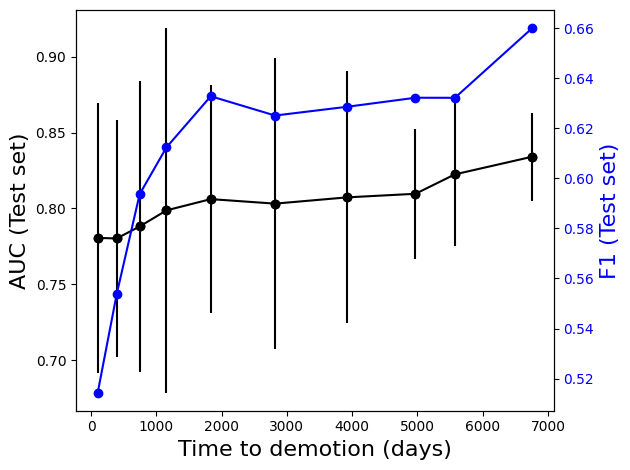

In [32]:
# Plotting with two y-axes
fig, ax1 = plt.subplots()
# Set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

color = 'black'
ax1.set_ylabel('AUC (Test set)', color=color, fontsize=16)
ax1.set_xlabel('Time to demotion (days)', color=color, fontsize=16)
ax1.plot(res_per_quantile_df['quantile'], res_per_quantile_df['test_auc'], color=color, marker='o')
#yerr = [(rpqd[1] - rpqd[0]) for rpqd in res_per_quantile_df['auc_ci']]
ax1.errorbar(res_per_quantile_df['quantile'], res_per_quantile_df['test_auc'], yerr=yerr, fmt='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_xticks(list(res_per_quantile_df['quantile']))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_facecolor('white')  # Ensure the second axes also has a white background

color = 'blue'
ax2.set_ylabel('F1 (Test set)', color=color, fontsize=16)
yerr = [(rpqd[1] - rpqd[0]) for rpqd in res_per_quantile_df['f1_ci']]
#ax2.errorbar(res_per_quantile_df['quantile'], res_per_quantile_df['test_f1'], yerr=yerr, fmt='o', color=color)
ax2.plot(res_per_quantile_df['quantile'], res_per_quantile_df['test_f1'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.title('Features Articles, English Wikipedia', fontsize=16)
plt.show()